## Train Auto-Encoders

In [1]:
import os
import numpy as np
import json

import torch
from torchvision import transforms as t
import torch.nn as nn
import torch.optim as optim


from utils import Fit
from model import Decoder, Encoder
from dataset import reshape_3d, get_train_ds_loader, get_test_ds_loader
from dataset import visualize_data, spliting_data_5_folds, map_target_values_to_labels
from loss import CombinedLoss


os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

LEARNING_RATE = 1e-5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 1
NUM_EPOCHS = 50
IMAGE_HEIGHT =  256
IMAGE_WIDTH =   256
IMAGE_DEPTH = 16

DATASET_DIR = 'MS_Dataset'

def main():
    ## reshpae the volumes 
    reshape = reshape_3d(height=IMAGE_HEIGHT, width=IMAGE_WIDTH, depth=IMAGE_DEPTH)
    def reshape_volume(x): return reshape(x)
    ##transforms
    general_transform = t.Compose([
       t.Lambda(reshape_volume),
    ])
    
    ## spliting the data into 5 folds
    folds_data = spliting_data_5_folds(DATASET_DIR)
    
    ## data loaders
    for fold_index in range(1):
        train_dl = get_train_ds_loader(dataset_dir=DATASET_DIR, data_dict=folds_data[fold_index], modality="FLAIR", 
                                       transform=general_transform, target_transform=general_transform, batch_size=BATCH_SIZE)
        test_dl = get_test_ds_loader(dataset_dir=DATASET_DIR, data_dict=folds_data[fold_index], modality="FLAIR",
                                     transform=general_transform, target_transform=general_transform, batch_size=BATCH_SIZE)
        
        
        ## loss function
        loss_fn = CombinedLoss()
        
        ## define the model
        encoder = Encoder(in_channels=1, filters=[32, 64, 128, 256, 512]).to(DEVICE)
        decoder = Decoder(out_channels=1, filters=[32, 64, 128, 256, 512]).to(DEVICE)
        
        optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=LEARNING_RATE)
        history = Fit(train_dl, test_dl, encoder, decoder, optimizer, loss_fn, DEVICE, epochs=NUM_EPOCHS)
        
        ## save the history in json file
        os.makedirs('history', exist_ok=True)
        history_path = os.path.join('history', f'history_fold_{fold_index}.json')
        with open(history_path, 'w') as f:
            json.dump(history, f)
            f.close()
        
        print(f"Fold {fold_index} is done!")
        print()
        

if __name__ == '__main__':
    main()

### Train Classifier

In [ ]:
import os
import numpy as np
import json

import torch
from torchvision import transforms as t
import torch.nn as nn
import torch.optim as optim


from model import  Encoder, SclerosisClassifier
from dataset import reshape_3d, get_train_ds_loader, get_test_ds_loader
from dataset import  spliting_data_5_folds
from classifier_utils import find_class_wise_accuracies

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

LEARNING_RATE = 1e-5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 1
NUM_EPOCHS = 25
IMAGE_HEIGHT =  256
IMAGE_WIDTH =   256
IMAGE_DEPTH = 16

DATASET_DIR = 'MS_Dataset'

def main():
    ## reshpae the volumes 
    reshape = reshape_3d(height=IMAGE_HEIGHT, width=IMAGE_WIDTH, depth=IMAGE_DEPTH)
    def reshape_volume(x): return reshape(x)
    ##transforms
    general_transform = t.Compose([
       t.Lambda(reshape_volume),
    ])
    
    ## spliting the data into 5 folds
    folds_data = spliting_data_5_folds(DATASET_DIR)
    
    ## data loaders
    for fold_index in range(1):
        train_dl = get_train_ds_loader(dataset_dir=DATASET_DIR, data_dict=folds_data[fold_index], modality="FLAIR", 
                                       transform=general_transform, target_transform=general_transform, batch_size=BATCH_SIZE)
        test_dl = get_test_ds_loader(dataset_dir=DATASET_DIR, data_dict=folds_data[fold_index], modality="FLAIR",
                                     transform=general_transform, target_transform=general_transform, batch_size=BATCH_SIZE)
        
        
        ## loss function
        loss_fn = nn.MSELoss()
        
        ## define the model
        encoder = Encoder(in_channels=1, filters=[32, 64, 128, 256, 512]).to(DEVICE)
        
        classifier = SclerosisClassifier(input_channels=512, ouptut_units=20).to(DEVICE)
        optimizer = optim.Adam(classifier.parameters(), lr=LEARNING_RATE)
        
        ## load the encoder weights
        encoder_weights_path = os.path.join('models', 'encoder.pth')
        encoder.load_state_dict(torch.load(encoder_weights_path))
        
        for param in encoder.parameters():
            param.requires_grad = False
        
        ## best accuracy
        best_test_accuracy = 0.0
        
        
        for epoch in range(NUM_EPOCHS):
            
            for batch, (x, _, sp_data) in enumerate(train_dl):
                x = x.to(DEVICE).unsqueeze(1)
            
            
                ## get the features from the encoder
                _, _, _, _, features = encoder(x)
            
                ## forward pass
                sp_features = sp_data['features'].to(DEVICE)
                sp_target = sp_data['target'].to(DEVICE)
                outputs = classifier(features, sp_features)
            
                ## calculate the loss
                loss = loss_fn(outputs, sp_target)
            
                ## backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            
                ##culculate the accuracy for 20 classes
                accuracy = []
            
                ## convert the probability to class
                outputs = torch.round(outputs)
                
                if batch % 10 == 0:
                    ## check the accuracy for each label sperately, muliti-class multi-label
                    for class_i in range(20):
                        accuracy.append((outputs[:, class_i] == sp_target[:, class_i]).sum().item())
                    
                    print('Epoch: {}/{}, Batch: {}/{}, Loss: {:.4f}, Accuracy: {}'.format(epoch+1, NUM_EPOCHS, batch+1, len(train_dl), loss.item(), np.mean(accuracy)))
                    #print(np.mean(accuracy))
            
            ## calculate the accuracy for 20 classes for test data
            train_accuracy = find_class_wise_accuracies(train_dl, classifier, encoder, DEVICE)
            test_accuracy = find_class_wise_accuracies(test_dl, classifier, encoder, DEVICE)
            
            print('Train Accuracy: {}, Test Accuracy: {}'.format(np.mean(train_accuracy), np.mean(test_accuracy)))
            
            if np.mean(test_accuracy) > best_test_accuracy:
                best_test_accuracy = np.mean(test_accuracy)
                print('Saving the best model...')
                ## save the model
                path = os.path.join('models', 'classifier.pth')
                torch.save(classifier.state_dict(), path)
                
        
            

if __name__ == '__main__':
    main()

### Evaluate the model

In [6]:
import os
import numpy as np
import json

import torch
from torchvision import transforms as t
import torch.nn as nn
import torch.optim as optim


from model import  Encoder, SclerosisClassifier
from dataset import reshape_3d, get_train_ds_loader, get_test_ds_loader
from dataset import  spliting_data_5_folds, map_target_values_to_labels
from classifier_utils import find_class_wise_accuracies

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 1
IMAGE_HEIGHT =  256
IMAGE_WIDTH =   256
IMAGE_DEPTH = 16

DATASET_DIR = 'MS_Dataset'

def main():
    ## reshpae the volumes 
    reshape = reshape_3d(height=IMAGE_HEIGHT, width=IMAGE_WIDTH, depth=IMAGE_DEPTH)
    def reshape_volume(x): return reshape(x)
    ##transforms
    general_transform = t.Compose([
       t.Lambda(reshape_volume),
    ])
    
    ## spliting the data into 5 folds
    folds_data = spliting_data_5_folds(DATASET_DIR)
    
    ## data loaders
    for fold_index in range(1):
        test_dl = get_test_ds_loader(dataset_dir=DATASET_DIR, data_dict=folds_data[fold_index], modality="FLAIR",
                                     transform=general_transform, target_transform=general_transform, batch_size=BATCH_SIZE)
        
        
        ## define the models
        encoder = Encoder(in_channels=1, filters=[32, 64, 128, 256, 512]).to(DEVICE) ## encoder
        classifier = SclerosisClassifier(input_channels=512, ouptut_units=20).to(DEVICE) ## classifier
        
        
        ## load the encoder weights
        encoder_weights_path = os.path.join('models', 'encoder.pth')
        
        if DEVICE == 'cuda':
            encoder.load_state_dict(torch.load(encoder_weights_path))
        else:
            encoder.load_state_dict(torch.load(encoder_weights_path, map_location=torch.device('cpu')))

        ## load the classifier weights
        classifier_weights_path = os.path.join('models', 'classifier.pth')
        if DEVICE == 'cuda':
            classifier.load_state_dict(torch.load(classifier_weights_path))
        else:
            classifier.load_state_dict(torch.load(classifier_weights_path, map_location=torch.device('cpu')))
        
       

        
        ## test the model
        accuracies = find_class_wise_accuracies(classifier=classifier, encoder=encoder,data_dl=test_dl, device=DEVICE)
        
        ## map the target values to labels
        values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10 ,11 ,12 ,13 ,14 ,15 ,16 ,17 ,18 ,19]
        dict_map = map_target_values_to_labels(values=values, dataset_dir=DATASET_DIR)
        
        ## print the accuracies
        for index, (key, value) in enumerate(dict_map.items()):
            print("Class: {}, Label: {}, Accuracy: {}".format(key, value, (round(accuracies[index] *100, 2))))
        
        print("\nOverall Mean Accuracy: {}\n\n".format(round(np.mean(accuracies), 2)*100))

   
            

if __name__ == '__main__':
    main()

Class: Pyramidal, Label: 0, Accuracy: 41.67
Class: Cerebella, Label: 1, Accuracy: 66.67
Class: Brain stem, Label: 2, Accuracy: 83.33
Class: Sensory, Label: 3, Accuracy: 50.0
Class: Sphincters, Label: 4, Accuracy: 75.0
Class: Visual, Label: 5, Accuracy: 58.33
Class: Mental, Label: 6, Accuracy: 83.33
Class: Speech, Label: 7, Accuracy: 83.33
Class: Motor System, Label: 8, Accuracy: 58.33
Class: Sensory System, Label: 9, Accuracy: 58.33
Class: Coordination, Label: 10, Accuracy: 66.67
Class: Gait, Label: 11, Accuracy: 75.0
Class: Bowel and bladder function, Label: 12, Accuracy: 75.0
Class: Mobility, Label: 13, Accuracy: 75.0
Class: Mental State, Label: 14, Accuracy: 66.67
Class: Optic discs, Label: 15, Accuracy: 58.33
Class: Fields, Label: 16, Accuracy: 91.67
Class: Nystagmus, Label: 17, Accuracy: 83.33
Class: Ocular Movement, Label: 18, Accuracy: 83.33
Class: Swallowing, Label: 19, Accuracy: 83.33

Overall Mean Accuracy: 71.0




### Output for the auto-encoder

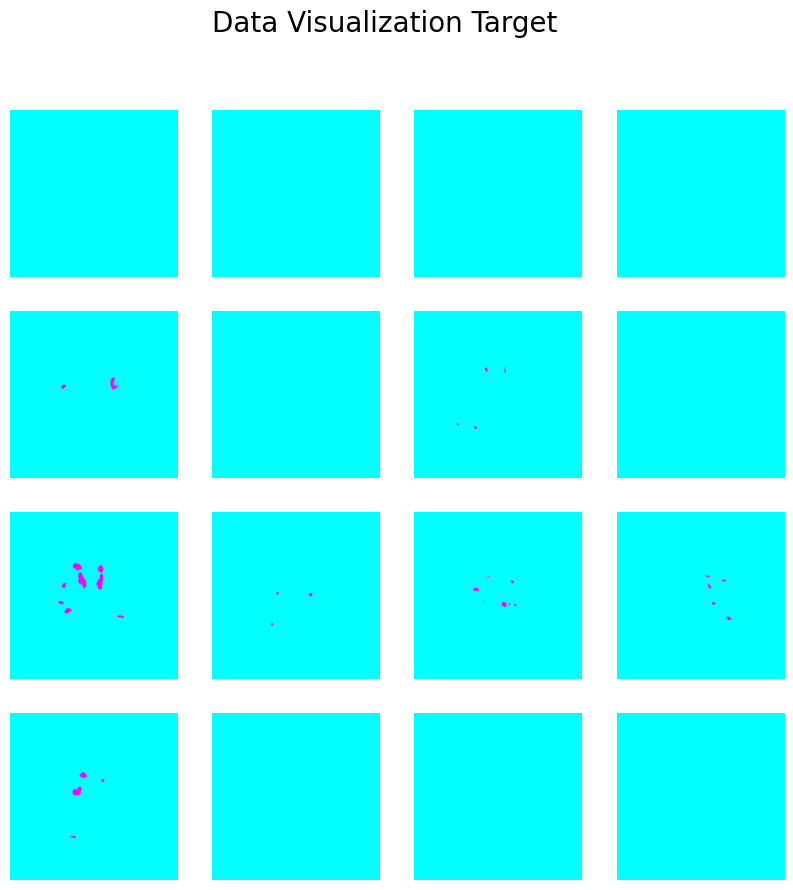

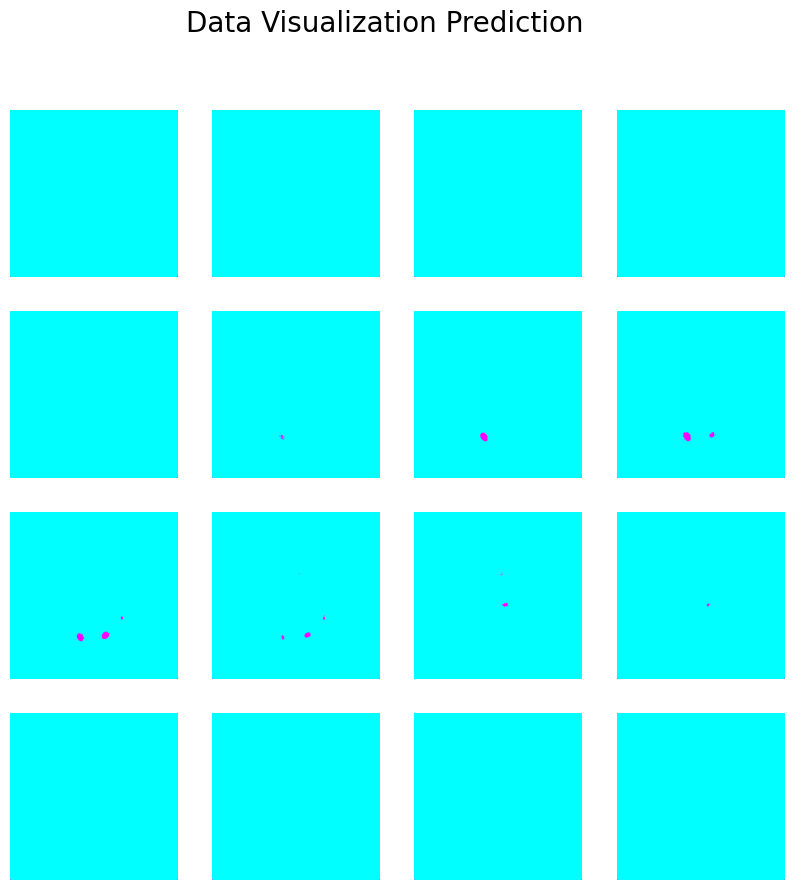



Decoder output shape: (256, 256, 16)
Encoder output shape: torch.Size([1, 512, 16, 16, 1])


In [2]:
import os
import numpy as np
import json

import torch
from torchvision import transforms as t
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from utils import Fit
from model import Decoder, Encoder
from dataset import reshape_3d, get_train_ds_loader, get_test_ds_loader
from dataset import spliting_data_5_folds, map_target_values_to_labels
from loss import CombinedLoss


os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

LEARNING_RATE = 1e-5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 1
NUM_EPOCHS = 50
IMAGE_HEIGHT =  256
IMAGE_WIDTH =   256
IMAGE_DEPTH = 16

DATASET_DIR = 'MS_Dataset'

def main(output_encoder=False, ouptut_decoder=False, test_index=0):
    ## reshpae the volumes 
    reshape = reshape_3d(height=IMAGE_HEIGHT, width=IMAGE_WIDTH, depth=IMAGE_DEPTH)
    def reshape_volume(x): return reshape(x)
    ##transforms
    general_transform = t.Compose([
       t.Lambda(reshape_volume),
    ])
    
    ## spliting the data into 5 folds
    folds_data = spliting_data_5_folds(DATASET_DIR)
    
    ## data loaders
    for fold_index in range(1):
        #train_dl = get_train_ds_loader(dataset_dir=DATASET_DIR, data_dict=folds_data[fold_index], modality="FLAIR", 
                                      # transform=general_transform, target_transform=general_transform, batch_size=BATCH_SIZE)
        test_dl = get_test_ds_loader(dataset_dir=DATASET_DIR, data_dict=folds_data[fold_index], modality="FLAIR",
                                     transform=general_transform, target_transform=general_transform, batch_size=BATCH_SIZE)
        
    
        
        ## define the model
        encoder = Encoder(in_channels=1, filters=[32, 64, 128, 256, 512]).to(DEVICE)
        decoder = Decoder(out_channels=1, filters=[32, 64, 128, 256, 512]).to(DEVICE)
        
        ## models paths
        encoder_weights_path = os.path.join('models', 'encoder.pth')
        decoder_weights_path = os.path.join('models', 'decoder.pth')
        
        ## check for cuda, if not load the model on cpu
        if DEVICE == 'cuda':
            encoder.load_state_dict(torch.load(encoder_weights_path))
            decoder.load_state_dict(torch.load(decoder_weights_path))
        else:
            encoder.load_state_dict(torch.load(encoder_weights_path, map_location=torch.device('cpu')))
            decoder.load_state_dict(torch.load(decoder_weights_path, map_location=torch.device('cpu')))
        
        
        for param in encoder.parameters():
            param.requires_grad = False
        for param in decoder.parameters():
            param.requires_grad = False
            
        ## check if the test_index is less than the length of the test data loader
        if test_index >= len(test_dl):
            raise ValueError("test_index must be less than the length of the test data loader")
        
        ## get the data for the test_index batch
        for batch, (x, y, _) in enumerate(test_dl):
            if batch == test_index:
                x = x.to(DEVICE).unsqueeze(1)
                y = y.to(DEVICE).unsqueeze(1)
                break
        
        
        ## get the prediction from the model
        if output_encoder:
            _, _, _, _, features = encoder(x)
        
        elif ouptut_decoder:
            x1, x2, x3, x4, features = encoder(x)
            outputs = decoder(x1, x2, x3, x4, features)
            
            #prediction = torch.round(outputs)
            prediction = nn.Sigmoid()(outputs)
            prediction = torch.where(prediction > 0.15, 1.0, 0.0)
            
            
            ## prepare the data for visualization
            prediction = prediction.squeeze(0).squeeze(0)
            y = y.squeeze(0).squeeze(0)
            
            ## convert to numpy
            prediction = prediction.detach().cpu().numpy().astype(np.uint8)
            y = y.detach().cpu().numpy().astype(np.uint8)
            
            visualize_data(data=y, slices=16, title='Target')
            visualize_data(data=prediction, slices=16, title='Prediction')
            
        print()
        
        return features if output_encoder else prediction if ouptut_decoder else None
 
def visualize_data(data, slices, title, figure_size=(10, 10)):
    plt.figure(figsize=figure_size)
    
    ##figure title
    plt.suptitle('Data Visualization {}'.format(title), fontsize=20)
    for i in range(slices):
        plt.subplot(4, 4, i+1)
        plt.imshow(data[:, :, i], cmap='cool')
        plt.axis('off')
    plt.show()


if __name__ == '__main__':
    random_index = np.random.randint(0, 12)
    predictions = main(output_encoder=False, ouptut_decoder=True, test_index=random_index)  
    features = main(output_encoder=True, ouptut_decoder=False, test_index=random_index)
    print("Decoder output shape: {}".format(predictions.shape))
    print("Encoder output shape: {}".format(features.shape))
    
    
    